In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds


In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    "stl10",
    split=["train", "test"],
    as_supervised=True,
    with_info=True
)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/stl10/incomplete.PGIY6J_1.0.0/stl10-train.tfrecord*...:   0%|          | 0…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/stl10/incomplete.PGIY6J_1.0.0/stl10-test.tfrecord*...:   0%|          | 0/…

Generating unlabelled examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/stl10/incomplete.PGIY6J_1.0.0/stl10-unlabelled.tfrecord*...:   0%|        …

Dataset stl10 downloaded and prepared to /root/tensorflow_datasets/stl10/1.0.0. Subsequent calls will reuse this data.


In [4]:
print(ds_info)


tfds.core.DatasetInfo(
    name='stl10',
    full_name='stl10/1.0.0',
    description="""
    The STL-10 dataset is an image recognition dataset for developing unsupervised
    feature learning, deep learning, self-taught learning algorithms. It is inspired
    by the CIFAR-10 dataset but with some modifications. In particular, each class
    has fewer labeled training examples than in CIFAR-10, but a very large set of
    unlabeled examples is provided to learn image models prior to supervised
    training. The primary challenge is to make use of the unlabeled data (which
    comes from a similar but different distribution from the labeled data) to build
    a useful prior. All images were acquired from labeled examples on ImageNet.
    """,
    homepage='http://ai.stanford.edu/~acoates/stl10/',
    data_dir='/root/tensorflow_datasets/stl10/1.0.0',
    file_format=tfrecord,
    download_size=2.46 GiB,
    dataset_size=1.86 GiB,
    features=FeaturesDict({
        'image': Image(shape=

In [5]:
NUM_CLASSES = 10
BATCH_SIZE = 64

def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


In [6]:
ds_train = ds_train.map(preprocess).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test  = ds_test.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [7]:
VAL_SIZE = 1000

ds_val = ds_train.take(VAL_SIZE // BATCH_SIZE)
ds_train = ds_train.skip(VAL_SIZE // BATCH_SIZE)


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    Conv2D(32, 3, activation="relu", padding="same", input_shape=(96,96,3)),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(64, 3, activation="relu", padding="same"),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(128, 3, activation="relu", padding="same"),
    BatchNormalization(),
    MaxPooling2D(),

    Flatten(),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation="softmax")
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [10]:
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=30
)


Epoch 1/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.2439 - loss: 4.2615 - val_accuracy: 0.1594 - val_loss: 7.1822
Epoch 2/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.2977 - loss: 1.9338 - val_accuracy: 0.1177 - val_loss: 7.1664
Epoch 3/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.3042 - loss: 1.7672 - val_accuracy: 0.1844 - val_loss: 2.4248
Epoch 4/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.3296 - loss: 1.7097 - val_accuracy: 0.1875 - val_loss: 2.4207
Epoch 5/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.3735 - loss: 1.6287 - val_accuracy: 0.2708 - val_loss: 2.2573
Epoch 6/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.3688 - loss: 1.6121 - val_accuracy: 0.2771 - val_loss: 2.1967
Epoch 7/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.3781 - loss: 1.5747 - val_accuracy: 0.3562 - val_loss: 2.0113
Epoch 8/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.4037 - loss: 1.5312 - val_accuracy: 0.4698 -

In [11]:
loss, acc = model.evaluate(ds_test)
print(f"Test accuracy : {acc:.3f}")


125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.6044 - loss: 1.4220
Test accuracy : 0.612


In [12]:
model.save("cnn_stl10.keras")


In [13]:
print("Classes:", ds_info.features["label"].num_classes)
print("Noms classes:", ds_info.features["label"].names)
print("Image shape:", ds_info.features["image"].shape)


Classes: 10
Noms classes: ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
Image shape: (96, 96, 3)


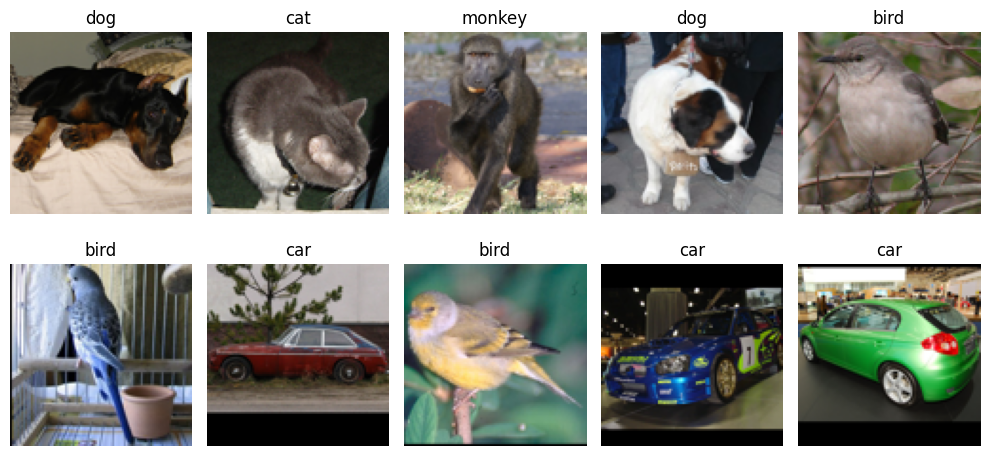

In [14]:
import matplotlib.pyplot as plt

class_names = ds_info.features["label"].names

plt.figure(figsize=(10,5))
for i, (img, lab) in enumerate(ds_train.unbatch().take(10)):
    plt.subplot(2,5,i+1)
    plt.imshow(img.numpy())
    plt.title(class_names[tf.argmax(lab).numpy()])
    plt.axis("off")
plt.tight_layout()
plt.show()


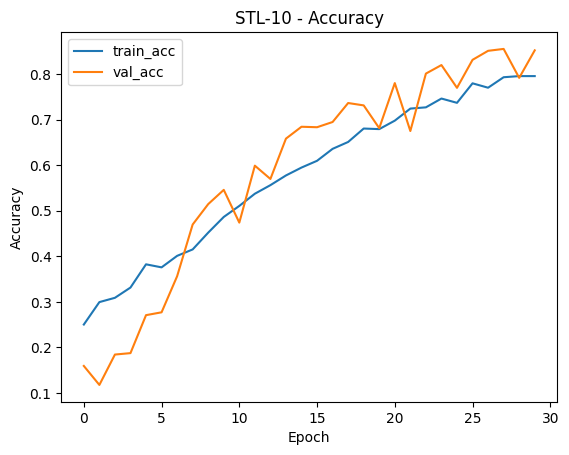

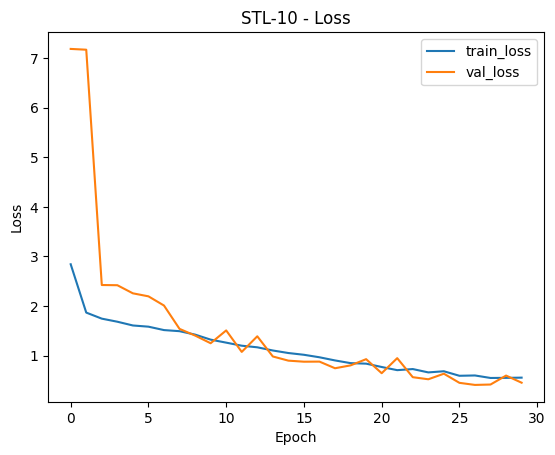

In [15]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure()
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("STL-10 - Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss
plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("STL-10 - Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [16]:
results = model.evaluate(ds_test, verbose=0)
for name, value in zip(model.metrics_names, results):
    print(f"{name:10s}: {value:.4f}")


loss      : 1.4014
compile_metrics: 0.6115


In [17]:
import numpy as np

# Récupérer des batchs en numpy (attention: ne pas faire sur tout si tu veux être ultra-rapide)
y_true = []
y_pred = []
x_imgs = []

for batch_imgs, batch_labels in ds_test.take(50):  # 50 batchs ~ 50*64 images (ajuste)
    preds = model.predict(batch_imgs, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(batch_labels.numpy(), axis=1))
    x_imgs.extend(batch_imgs.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
x_imgs = np.array(x_imgs)

print("Nb samples évalués:", len(y_true))


Nb samples évalués: 3200


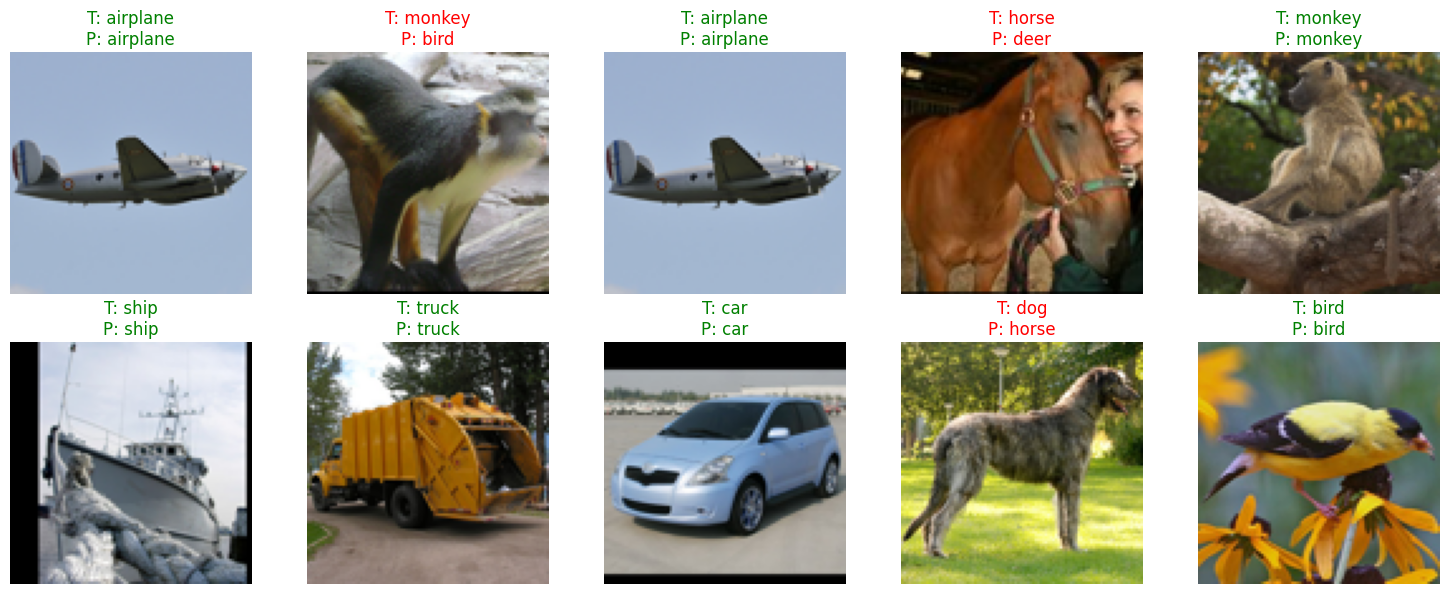

In [18]:
import matplotlib.pyplot as plt

class_names = ds_info.features["label"].names

def show_random_predictions(x, y_true, y_pred, n=10):
    plt.figure(figsize=(15,6))
    for i in range(n):
        idx = np.random.randint(0, len(x))
        plt.subplot(2, n//2, i+1)
        plt.imshow(x[idx])
        plt.axis("off")
        t = class_names[y_true[idx]]
        p = class_names[y_pred[idx]]
        color = "green" if y_true[idx] == y_pred[idx] else "red"
        plt.title(f"T: {t}\nP: {p}", color=color)
    plt.tight_layout()
    plt.show()

show_random_predictions(x_imgs, y_true, y_pred, n=10)


# Transfert learning

In [19]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input


In [20]:
NUM_CLASSES = 10
BATCH_SIZE = 64
IMG_SIZE = (96, 96)  # STL-10 natif


In [21]:
def preprocess_tl(image, label):
    image = tf.cast(image, tf.float32)
    image = preprocess_input(image)  # IMPORTANT
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


In [22]:
(ds_train, ds_test), ds_info = tfds.load(
    "stl10",
    split=["train", "test"],
    as_supervised=True,
    with_info=True
)


In [23]:
ds_train = ds_train.map(preprocess_tl).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test  = ds_test.map(preprocess_tl).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [24]:
VAL_SIZE = 1000
ds_val = ds_train.take(VAL_SIZE // BATCH_SIZE)
ds_train = ds_train.skip(VAL_SIZE // BATCH_SIZE)


In [25]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model


In [26]:
base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(96,96,3)
)

base_model.trainable = False  # GEL DES POIDS


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [27]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(NUM_CLASSES, activation="softmax")(x)

model_tl = Model(inputs=base_model.input, outputs=output)


In [28]:
model_tl.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [29]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.5, min_lr=1e-5)
]


In [30]:
history_tl = model_tl.fit(
    ds_train,
    validation_data=ds_val,
    epochs=20,
    callbacks=callbacks
)


Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 36s 291ms/step - accuracy: 0.2260 - loss: 2.4529 - val_accuracy: 0.8250 - val_loss: 0.8707 - learning_rate: 1.0000e-04
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.7247 - loss: 0.9707 - val_accuracy: 0.9010 - val_loss: 0.4400 - learning_rate: 1.0000e-04
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.8377 - loss: 0.6060 - val_accuracy: 0.9208 - val_loss: 0.3100 - learning_rate: 1.0000e-04
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.8794 - loss: 0.4181 - val_accuracy: 0.9281 - val_loss: 0.2541 - learning_rate: 1.0000e-04
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.8976 - loss: 0.3471 - val_accuracy: 0.9438 - val_loss: 0.2044 - learning_rate: 1.0000e-04
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.9038 - loss: 0.3088 - val_accuracy: 0.9448 - val_loss: 0.1857 - learning_rate: 1.0000e-04
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.910

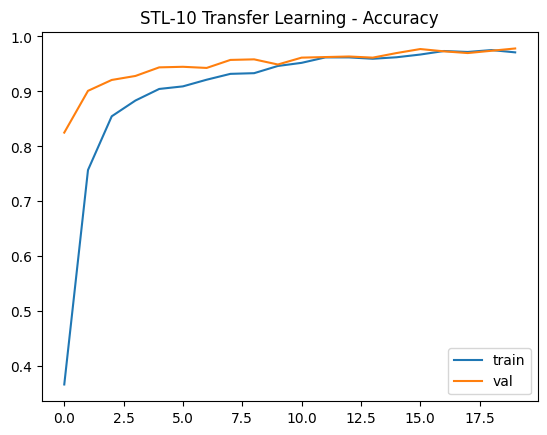

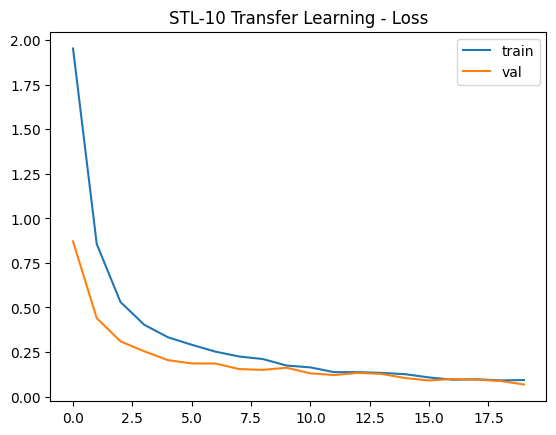

In [31]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history_tl.history["accuracy"], label="train")
plt.plot(history_tl.history["val_accuracy"], label="val")
plt.title("STL-10 Transfer Learning - Accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(history_tl.history["loss"], label="train")
plt.plot(history_tl.history["val_loss"], label="val")
plt.title("STL-10 Transfer Learning - Loss")
plt.legend()
plt.show()


In [32]:
loss, acc = model_tl.evaluate(ds_test)
print(f"Test accuracy (TL) : {acc:.3f}")


125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.9370 - loss: 0.1995
Test accuracy (TL) : 0.938


In [33]:
import numpy as np

class_names = ds_info.features["label"].names

y_true, y_pred, x_imgs = [], [], []

for imgs, labels in ds_test.take(20):
    preds = model_tl.predict(imgs, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    x_imgs.extend(imgs.numpy())


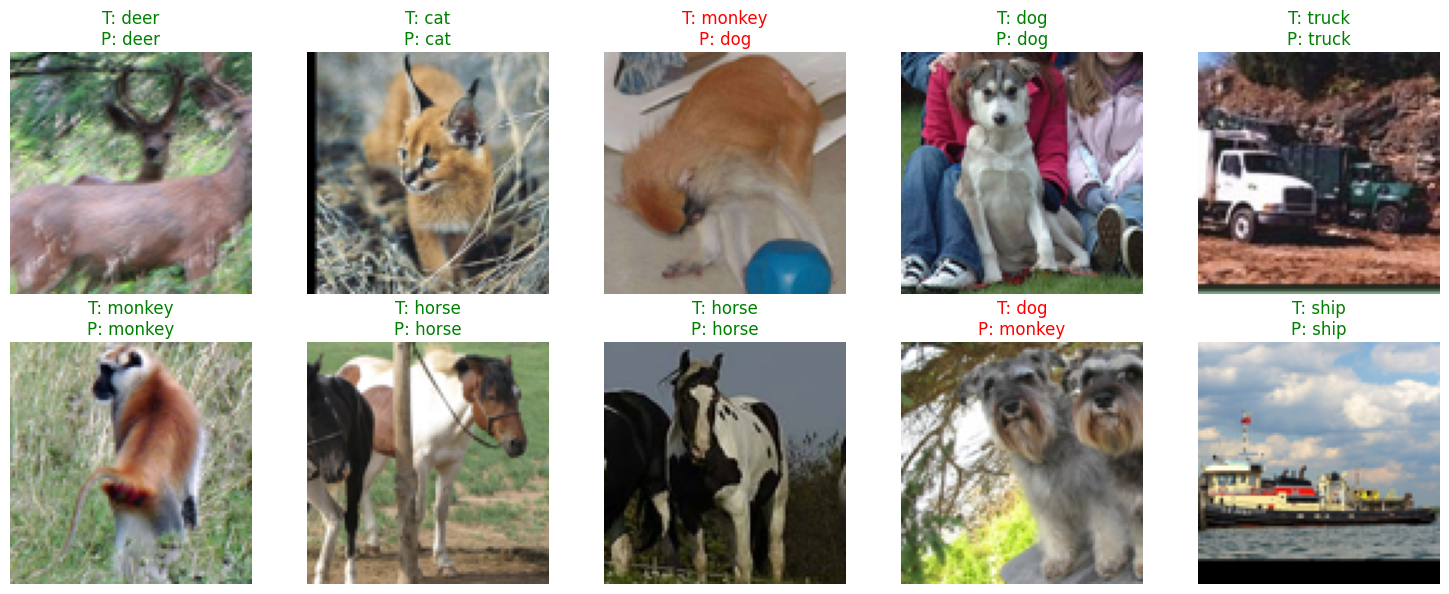

In [34]:
def show_predictions(x, y_true, y_pred, n=10):
    plt.figure(figsize=(15,6))
    for i in range(n):
        idx = np.random.randint(0, len(x))
        plt.subplot(2, n//2, i+1)
        plt.imshow((x[idx] + 1) / 2)  # inverse preprocess_input
        plt.axis("off")
        color = "green" if y_true[idx] == y_pred[idx] else "red"
        plt.title(f"T: {class_names[y_true[idx]]}\nP: {class_names[y_pred[idx]]}", color=color)
    plt.tight_layout()
    plt.show()

show_predictions(np.array(x_imgs), np.array(y_true), np.array(y_pred))


In [35]:
model_tl.save("mobilenet_stl10_transfer_learning.keras")